In [11]:
import itertools
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score


In [15]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Convert categorical → numeric
df_encoded = pd.get_dummies(df, drop_first=True)

y = df['Attrition'].map({'Yes':1, 'No':0}).values
X = df_encoded.drop(columns=['Attrition_Yes'], errors='ignore').values


In [21]:
from sklearn.feature_selection import VarianceThreshold

def make_pipeline(classifier):
    return Pipeline([
        ('var', VarianceThreshold(threshold=0.0)),   # remove constant features
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_classif)),
        ('classifier', classifier)
    ])


In [22]:
def run_manual_grid_search(X, y, classifier, param_grid):
    best_score = -1
    best_params = None
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        scores = []

        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            pipeline = make_pipeline(classifier)
            pipeline.set_params(**params)
            pipeline.fit(X_train, y_train)

            y_pred = pipeline.predict_proba(X_val)[:, 1]
            scores.append(roc_auc_score(y_val, y_pred))

        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = params

    best_pipeline = make_pipeline(classifier)
    best_pipeline.set_params(**best_params)
    best_pipeline.fit(X, y)
    return best_pipeline, best_params, best_score

def run_builtin_grid_search(X, y, classifier, param_grid):
    pipeline = make_pipeline(classifier)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1
    )
    grid.fit(X, y)

    return grid.best_estimator_, grid.best_params_, grid.best_score_


In [23]:
param_grid_dt = {
    'selector__k': [5, 10, 15],
    'classifier__max_depth': [3, 5, None],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_knn = {
    'selector__k': [5, 10, 15],
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

param_grid_lr = {
    'selector__k': [5, 10, 15],
    'classifier__C': [0.01, 0.1, 1, 10]
}


In [24]:
from sklearn.tree import DecisionTreeClassifier

best_pipeline_dt, best_params_dt, best_score_dt = run_manual_grid_search(
    X, y, DecisionTreeClassifier(), param_grid_dt
)

best_estimator_dt, best_params_dt_builtin, best_score_dt_builtin = run_builtin_grid_search(
    X, y, DecisionTreeClassifier(), param_grid_dt
)

print("--- Decision Tree ---")
print("Manual:", best_params_dt, best_score_dt)
print("GridSearchCV:", best_params_dt_builtin, best_score_dt_builtin)


--- Decision Tree ---
Manual: {'selector__k': 15, 'classifier__max_depth': 5, 'classifier__min_samples_split': 5} 0.73983692054758
GridSearchCV: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'selector__k': 10} 0.7378834626192975


In [25]:
from sklearn.neighbors import KNeighborsClassifier

best_pipeline_knn, best_params_knn, best_score_knn = run_manual_grid_search(
    X, y, KNeighborsClassifier(), param_grid_knn
)

best_estimator_knn, best_params_knn_builtin, best_score_knn_builtin = run_builtin_grid_search(
    X, y, KNeighborsClassifier(), param_grid_knn
)

print("--- kNN ---")
print("Manual:", best_params_knn, best_score_knn)
print("GridSearchCV:", best_params_knn_builtin, best_score_knn_builtin)


--- kNN ---
Manual: {'selector__k': 15, 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'} 0.7058241975842965
GridSearchCV: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance', 'selector__k': 15} 0.7058241975842965


In [26]:
from sklearn.linear_model import LogisticRegression

best_pipeline_lr, best_params_lr, best_score_lr = run_manual_grid_search(
    X, y, LogisticRegression(max_iter=1000), param_grid_lr
)

best_estimator_lr, best_params_lr_builtin, best_score_lr_builtin = run_builtin_grid_search(
    X, y, LogisticRegression(max_iter=1000), param_grid_lr
)

print("--- Logistic Regression ---")
print("Manual:", best_params_lr, best_score_lr)
print("GridSearchCV:", best_params_lr_builtin, best_score_lr_builtin)


--- Logistic Regression ---
Manual: {'selector__k': 15, 'classifier__C': 0.1} 0.7817249609043164
GridSearchCV: {'classifier__C': 0.1, 'selector__k': 15} 0.7817249609043164


In [27]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(name, model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    return {
        "Model": name,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1": f1_score(y, y_pred),
        "ROC AUC": roc_auc_score(y, y_proba)
    }

results = []
results.append(evaluate_model("Decision Tree (Manual)", best_pipeline_dt, X, y))
results.append(evaluate_model("Decision Tree (GridSearchCV)", best_estimator_dt, X, y))

results.append(evaluate_model("kNN (Manual)", best_pipeline_knn, X, y))
results.append(evaluate_model("kNN (GridSearchCV)", best_estimator_knn, X, y))

results.append(evaluate_model("Logistic Regression (Manual)", best_pipeline_lr, X, y))
results.append(evaluate_model("Logistic Regression (GridSearchCV)", best_estimator_lr, X, y))

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


                                Model  Accuracy  Precision    Recall  \
0              Decision Tree (Manual)  0.880952   0.869048  0.308017   
1        Decision Tree (GridSearchCV)  0.859864   0.792453  0.177215   
2                        kNN (Manual)  1.000000   1.000000  1.000000   
3                  kNN (GridSearchCV)  1.000000   1.000000  1.000000   
4        Logistic Regression (Manual)  0.863946   0.707865  0.265823   
5  Logistic Regression (GridSearchCV)  0.863946   0.707865  0.265823   

         F1   ROC AUC  
0  0.454829  0.825776  
1  0.289655  0.761251  
2  1.000000  1.000000  
3  1.000000  1.000000  
4  0.386503  0.814055  
5  0.386503  0.814055  


<Figure size 1000x800 with 0 Axes>

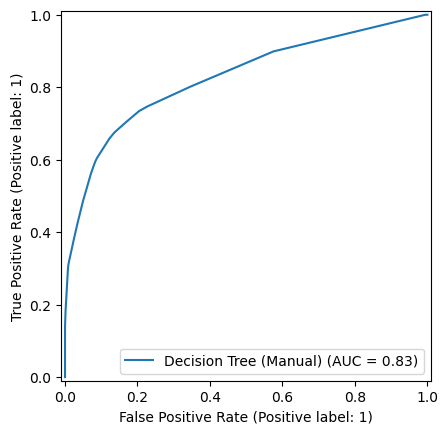

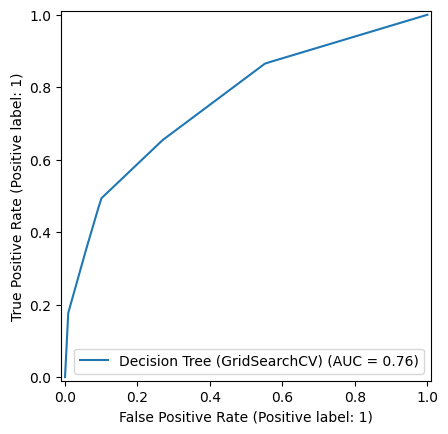

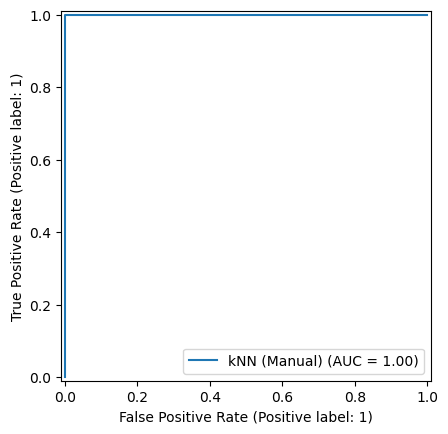

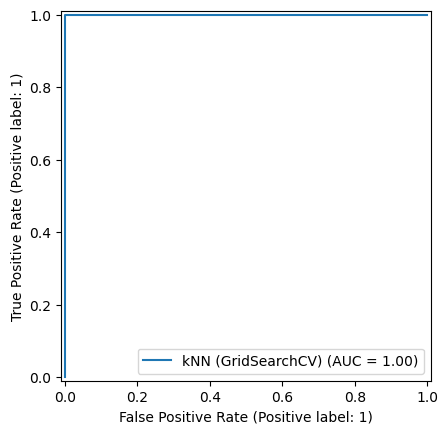

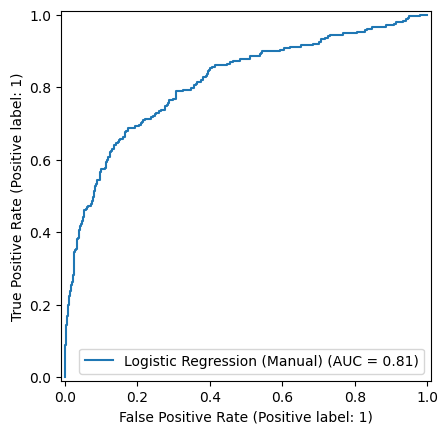

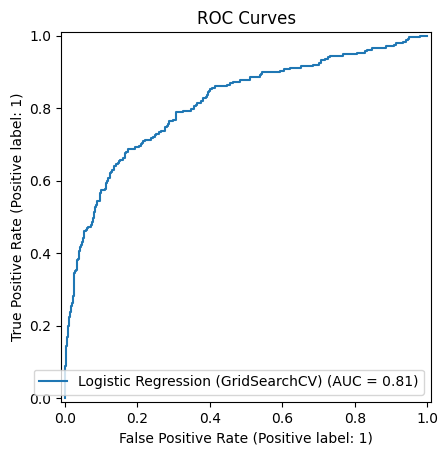

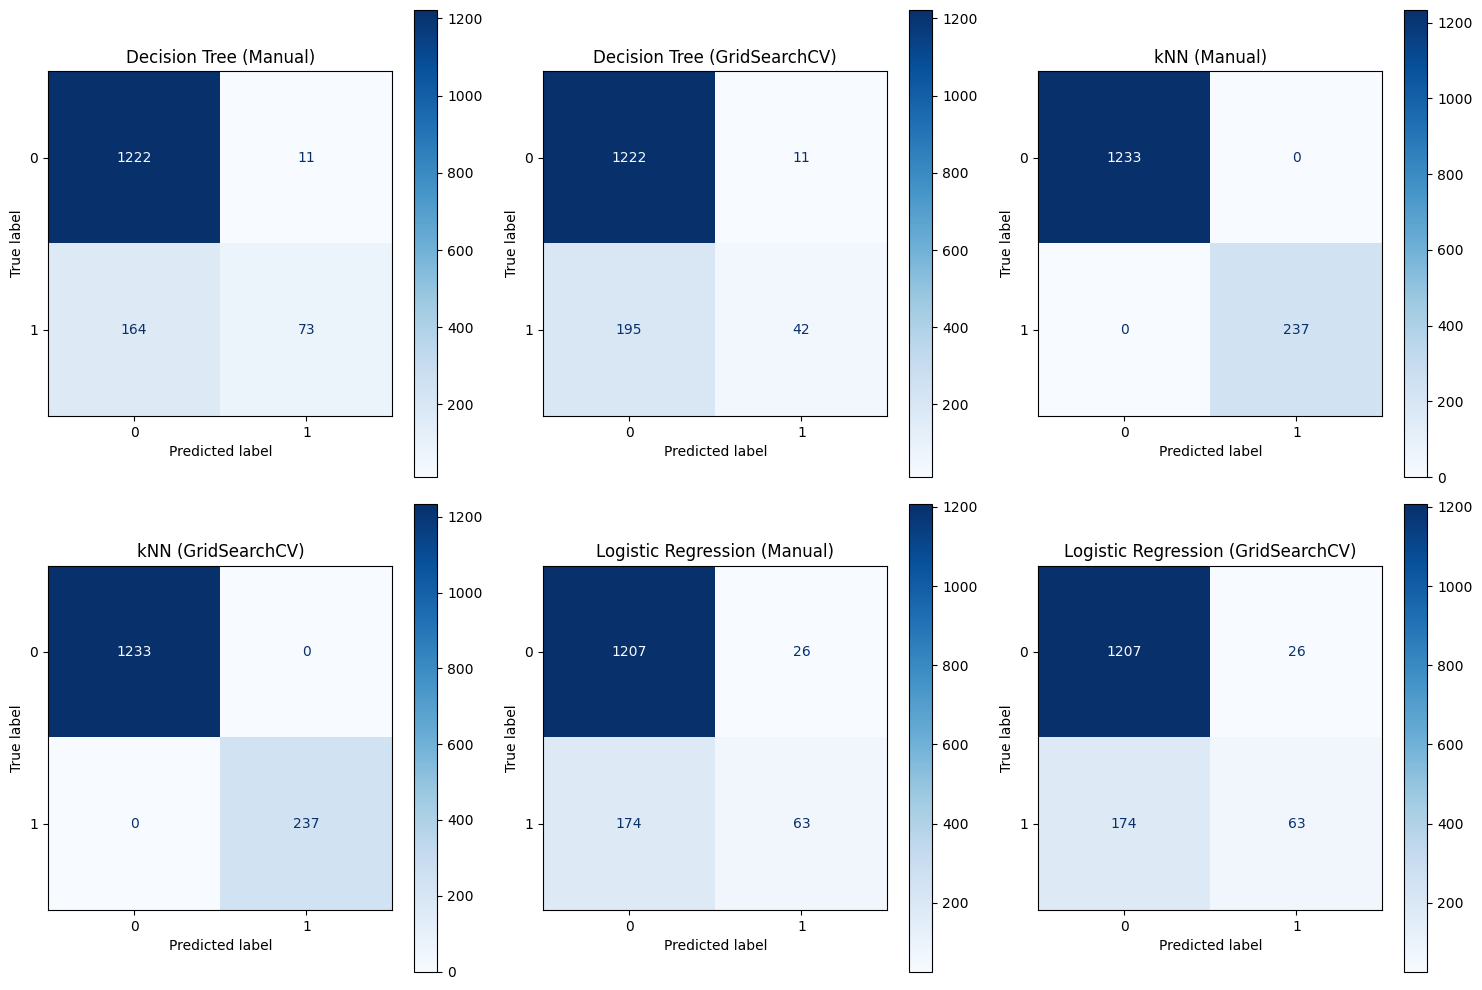

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

models = [
    ("Decision Tree (Manual)", best_pipeline_dt),
    ("Decision Tree (GridSearchCV)", best_estimator_dt),
    ("kNN (Manual)", best_pipeline_knn),
    ("kNN (GridSearchCV)", best_estimator_knn),
    ("Logistic Regression (Manual)", best_pipeline_lr),
    ("Logistic Regression (GridSearchCV)", best_estimator_lr),
]

# ROC Curves
plt.figure(figsize=(10, 8))
for name, model in models:
    RocCurveDisplay.from_estimator(model, X, y, name=name)
plt.title("ROC Curves")
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (name, model) in enumerate(models):
    ConfusionMatrixDisplay.from_estimator(model, X, y, ax=axes[i], cmap="Blues")
    axes[i].set_title(name)

plt.tight_layout()
plt.show()

